In [33]:
import re
from datasets import load_dataset
import spacy
from collections import Counter
import itertools
from tqdm import tqdm

# Load the English model in spaCy
nlp = spacy.load("en_core_web_sm")

# Load the dataset in streaming mode
dataset = load_dataset("HuggingFaceFW/fineweb", split='train', streaming=True)

# Parameters
num_data = 30000  # Adjust this number as needed

# Initialize counters and storage for PII data
pii_counts = Counter()
pii_values = Counter()
pii_counts_per_doc = []
extracted_pii_data = []

# Regex patterns for additional PII types
email_pattern = re.compile(r'\b[\w.%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
phone_pattern = re.compile(r'\b(?:\+?(\d{1,3})?[-.\s]?(\d{1,4})[-.\s]?(\d{1,4})[-.\s]?(\d{1,9}))\b')
ip_pattern = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')

# Modify the function to filter out years in the range 1900–2100 for phone numbers

# Function to validate PII entities
def is_valid_pii(entity, entity_type):
    if entity_type == 'PERSON':
        return entity.isalpha() and len(entity) > 1  # Basic name validation
    elif entity_type == 'PHONE_NUMBER':
        # Check if the phone number has at least 7 digits (adjust as needed)
        digits_only = re.sub(r'\D', '', entity)  # Remove non-numeric characters
        return len(digits_only) >= 7  # Require at least 7 digits to be valid
    elif entity_type == 'EMAIL':
        return re.match(r'^[\w\.-]+@[\w\.-]+\.\w+$', entity)  # Valid email format
    elif entity_type == 'IP_ADDRESS':
        return re.match(r'^\d{1,3}(\.\d{1,3}){3}$', entity)  # Simple IP format
    elif entity_type in ['LOC', 'GPE']:
        return entity.isalpha() and len(entity) > 2  # Exclude short numbers, generic codes, etc.
    return True


# Processing documents with tqdm
for sample in tqdm(itertools.islice(dataset, num_data), total=num_data, desc="Processing Documents"):
    text = sample['text']
    pii_count_in_doc = 0
    sample_pii = {'text': text, 'extracted_pii': {}}

    # Extract PII using spaCy for names, locations
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ in ['PERSON', 'GPE', 'LOC'] and is_valid_pii(ent.text, ent.label_):
            pii_counts[ent.label_] += 1
            pii_values[ent.text] += 1
            pii_count_in_doc += 1
            if ent.label_ not in sample_pii['extracted_pii']:
                sample_pii['extracted_pii'][ent.label_] = []
            sample_pii['extracted_pii'][ent.label_].append(ent.text)

    # Extract PII using regex for emails, phone numbers, IP addresses
    for pattern, label in [(email_pattern, 'EMAIL'), (phone_pattern, 'PHONE_NUMBER'), (ip_pattern, 'IP_ADDRESS')]:
        matches = pattern.findall(text)
        flattened_matches = [''.join(match) if isinstance(match, tuple) else match for match in matches]
        for match in flattened_matches:
            if is_valid_pii(match, label):
                pii_counts[label] += 1
                pii_values[match] += 1
                pii_count_in_doc += 1
                if label not in sample_pii['extracted_pii']:
                    sample_pii['extracted_pii'][label] = []
                sample_pii['extracted_pii'][label].append(match)

    pii_counts_per_doc.append(pii_count_in_doc)
    extracted_pii_data.append(sample_pii)

# Metrics and data for visualization
metrics = {
    'PII Counts by Type': pii_counts,
    'Top PII Instances': pii_values.most_common(10),
    'PII Counts per Document': pii_counts_per_doc,
    'Extracted PII Data': extracted_pii_data
}


Processing Documents: 100%|██████████| 30000/30000 [20:56<00:00, 23.87it/s]  


In [34]:
# Display extracted PII data (example)
print("\n--- Extracted PII Data (Sample) ---")
for i, pii_data in enumerate(extracted_pii_data[:3]):  # Display first 3 samples
    print(f"Sample {i+1}: {pii_data['extracted_pii']}")


--- Extracted PII Data (Sample) ---
Sample 1: {'GPE': ['Chicago', 'Georgia', 'Harrisburg', 'Georgia', 'Cleveland', 'Tennessee', 'CLEVELAND', 'Tennessee', 'States'], 'PERSON': ['Ray', 'Ray', 'Ray', 'Doppler', 'Ray', 'Ray', 'Ray'], 'LOC': ['South']}
Sample 2: {'PERSON': ['Jian'], 'GPE': ['Toronto']}
Sample 3: {'PERSON': ['Clara', 'Clara'], 'GPE': ['Kennewick', 'Clara', 'Pasco', 'Spokane'], 'PHONE_NUMBER': ['5093802321']}


Visualization

C:\Users\terry\AppData\Local\Temp\ipykernel_1385996\3244656915.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pii_counts_df, x='PII Type', y='Count', palette='Blues_d')


PII Counts by Type:
       PII Type   Count
0           GPE   92194
1        PERSON  114850
2           LOC    7540
3  PHONE_NUMBER    9459
4         EMAIL    1851
5    IP_ADDRESS     198


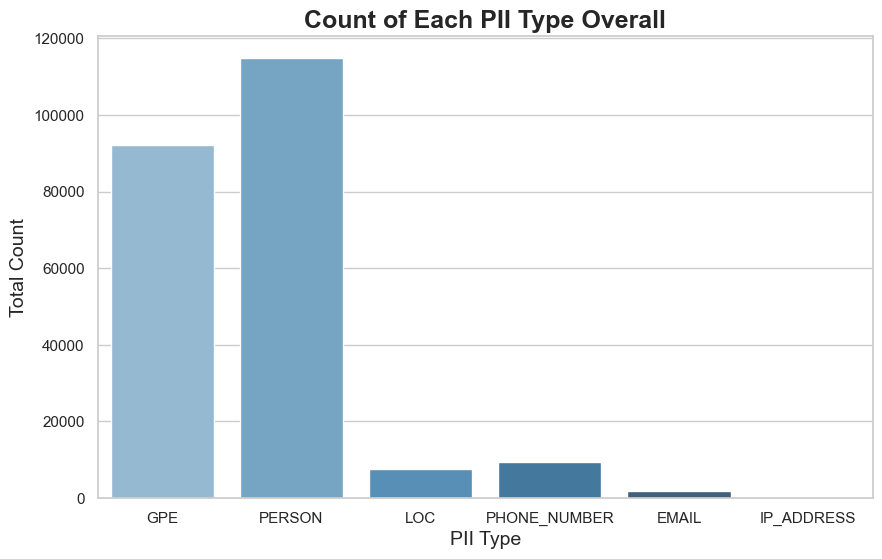


Rate of Each PII Type Occurring in Documents:
       PII Type  Documents with PII  Rate per Document (%)
0           GPE               16944              56.480000
1        PERSON               18871              62.903333
2           LOC                3649              12.163333
3  PHONE_NUMBER                3689              12.296667
4         EMAIL                1302               4.340000
5    IP_ADDRESS                  75               0.250000


C:\Users\terry\AppData\Local\Temp\ipykernel_1385996\3244656915.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pii_rate_df, x='PII Type', y='Rate per Document (%)', palette='Purples')


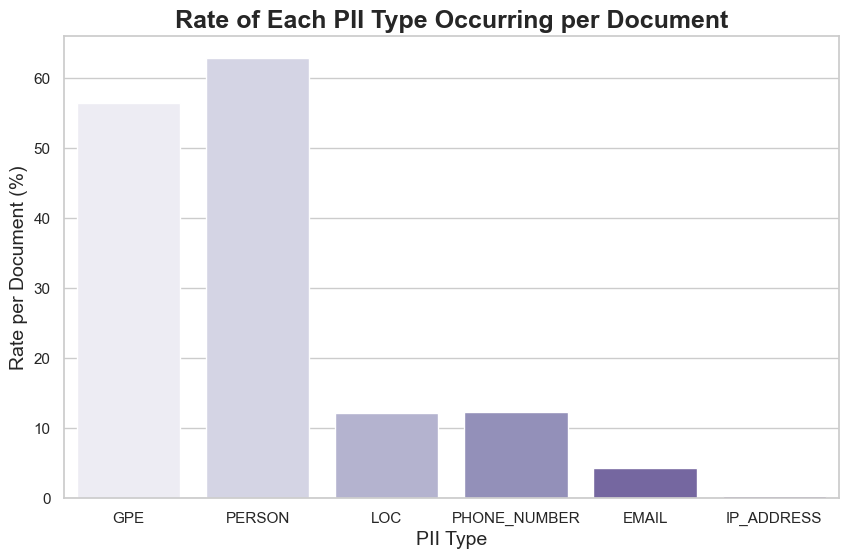


Top 50 Entities for PII Type 'GPE':
China: 1509
America: 1366
Washington: 1327
California: 1323
Canada: 1119
London: 1046
Florida: 1021
Japan: 976
Israel: 954
Texas: 925
Australia: 915
India: 909
Chicago: 861
France: 744
England: 691
Iraq: 664
Boston: 595
Germany: 575
Ohio: 574
USA: 559
Paris: 487
Georgia: 472
Italy: 467
Arizona: 454
Mexico: 446
Toronto: 442
Seattle: 440
Iran: 438
Russia: 433
Colorado: 429
Spain: 420
Ireland: 416
Michigan: 415
Dallas: 413
Syria: 403
Hollywood: 396
Britain: 395
Miami: 390
Portland: 389
Virginia: 386
Alabama: 383
Atlanta: 381
Brazil: 374
Massachusetts: 359
Houston: 358
Philadelphia: 353
Wisconsin: 353
Pakistan: 352
Afghanistan: 349
Utah: 334

Top 50 Entities for PII Type 'PERSON':
Obama: 2004
Jesus: 901
Twitter: 749
Bush: 537
John: 488
Paul: 376
Johnson: 373
Chris: 371
Brown: 330
Romney: 329
Jones: 328
James: 323
David: 284
Smith: 268
Williams: 262
Ryan: 258
Peter: 256
Jackson: 256
Jack: 250
Miller: 243
Adam: 241
Bill: 231
Michael: 227
Clinton: 227
Mary

C:\Users\terry\AppData\Local\Temp\ipykernel_1385996\3244656915.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(entities), y=list(counts), palette=valid_palettes[i % len(valid_palettes)])


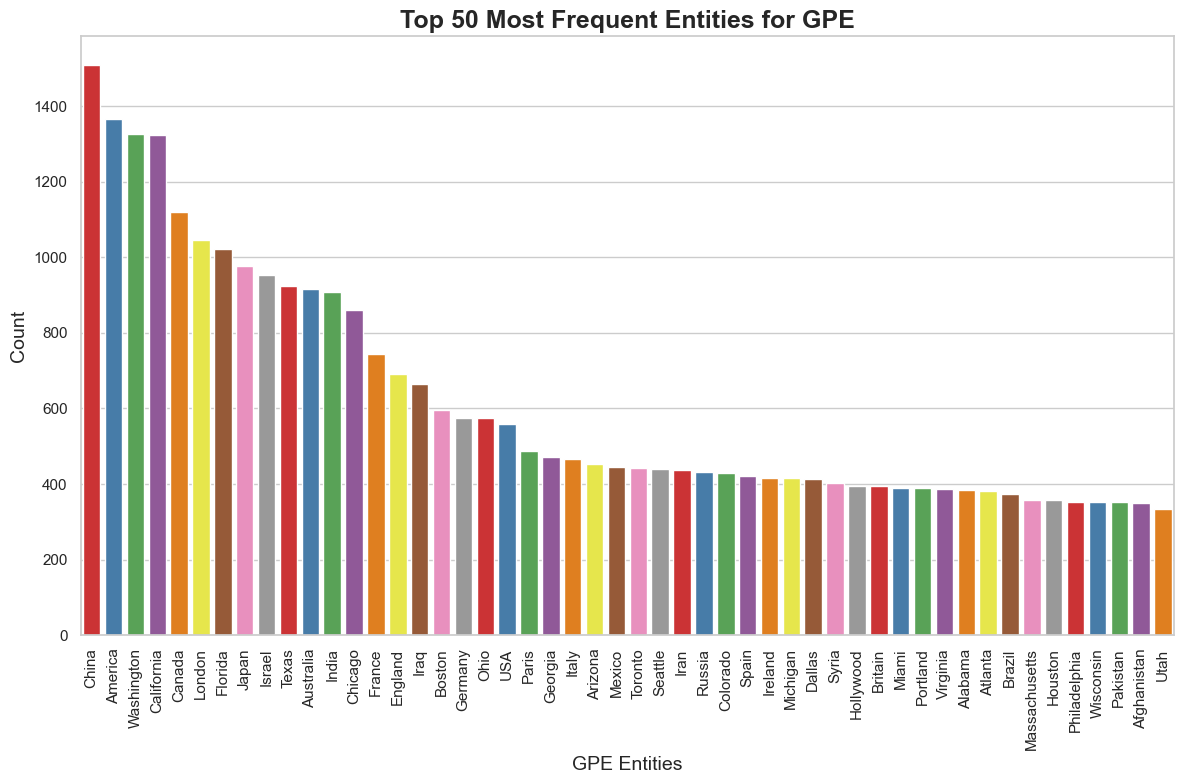

C:\Users\terry\AppData\Local\Temp\ipykernel_1385996\3244656915.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(entities), y=list(counts), palette=valid_palettes[i % len(valid_palettes)])


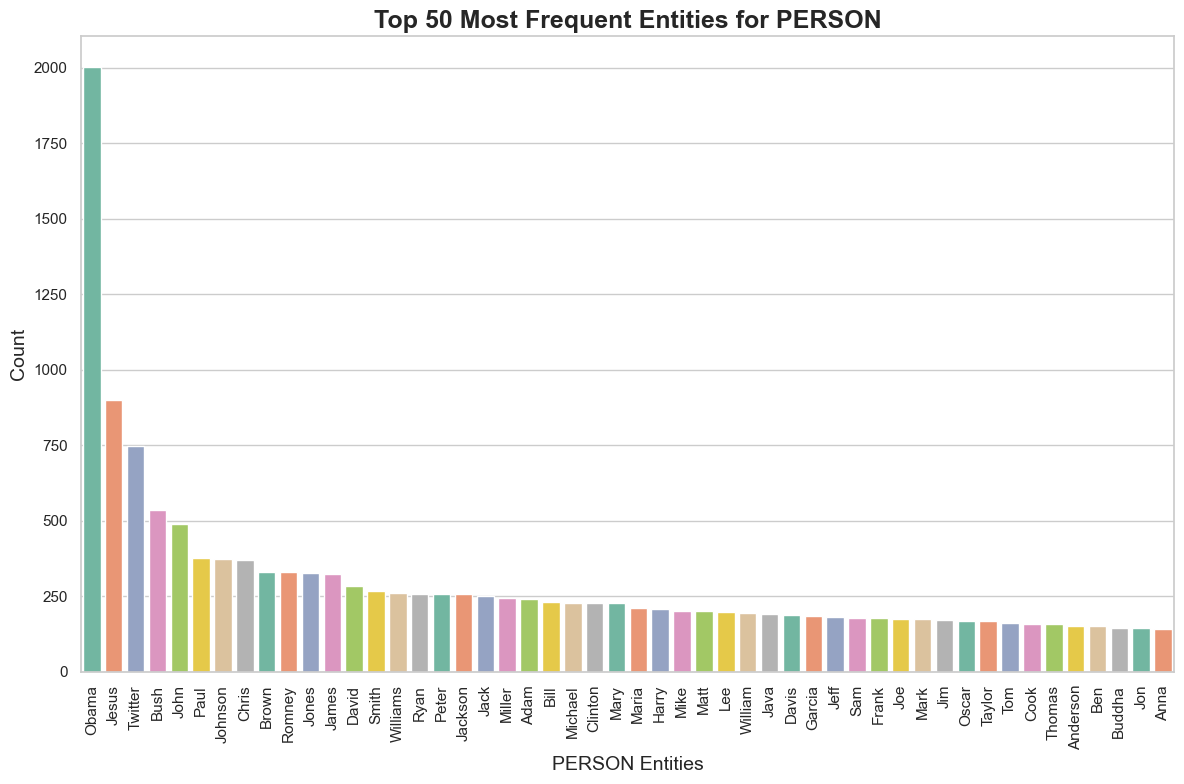

C:\Users\terry\AppData\Local\Temp\ipykernel_1385996\3244656915.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(entities), y=list(counts), palette=valid_palettes[i % len(valid_palettes)])


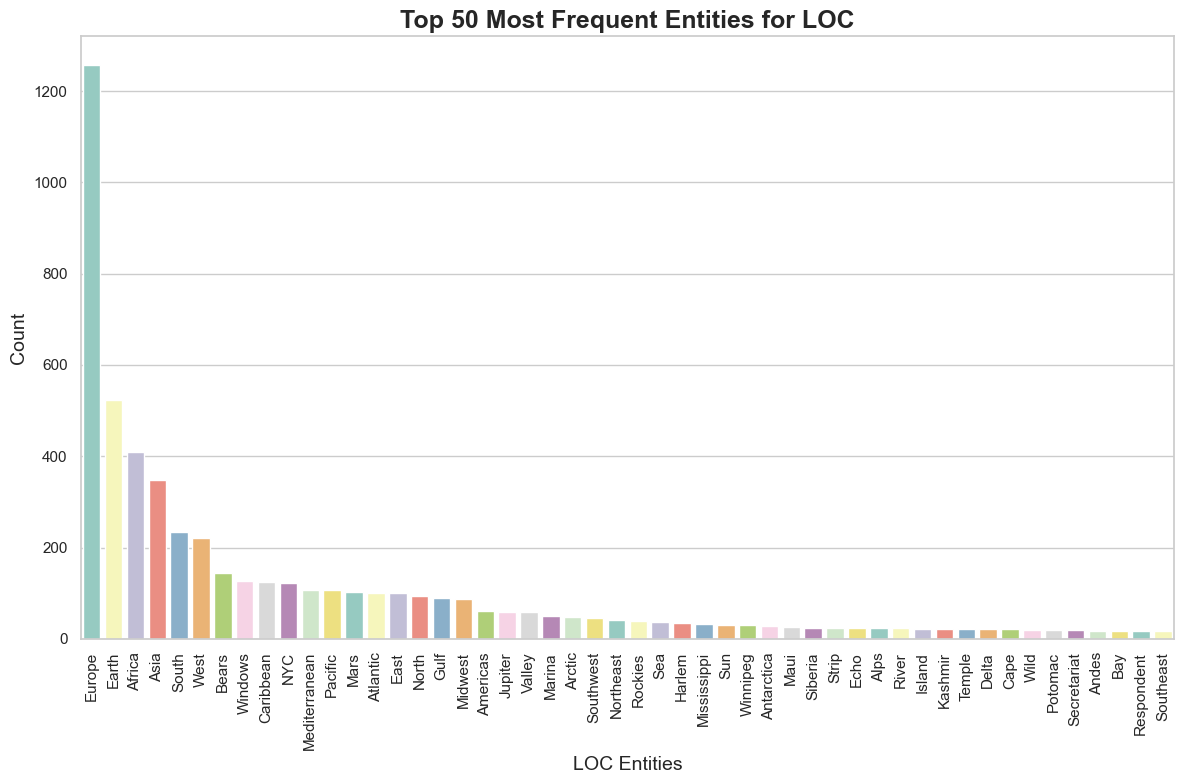

C:\Users\terry\AppData\Local\Temp\ipykernel_1385996\3244656915.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(entities), y=list(counts), palette=valid_palettes[i % len(valid_palettes)])


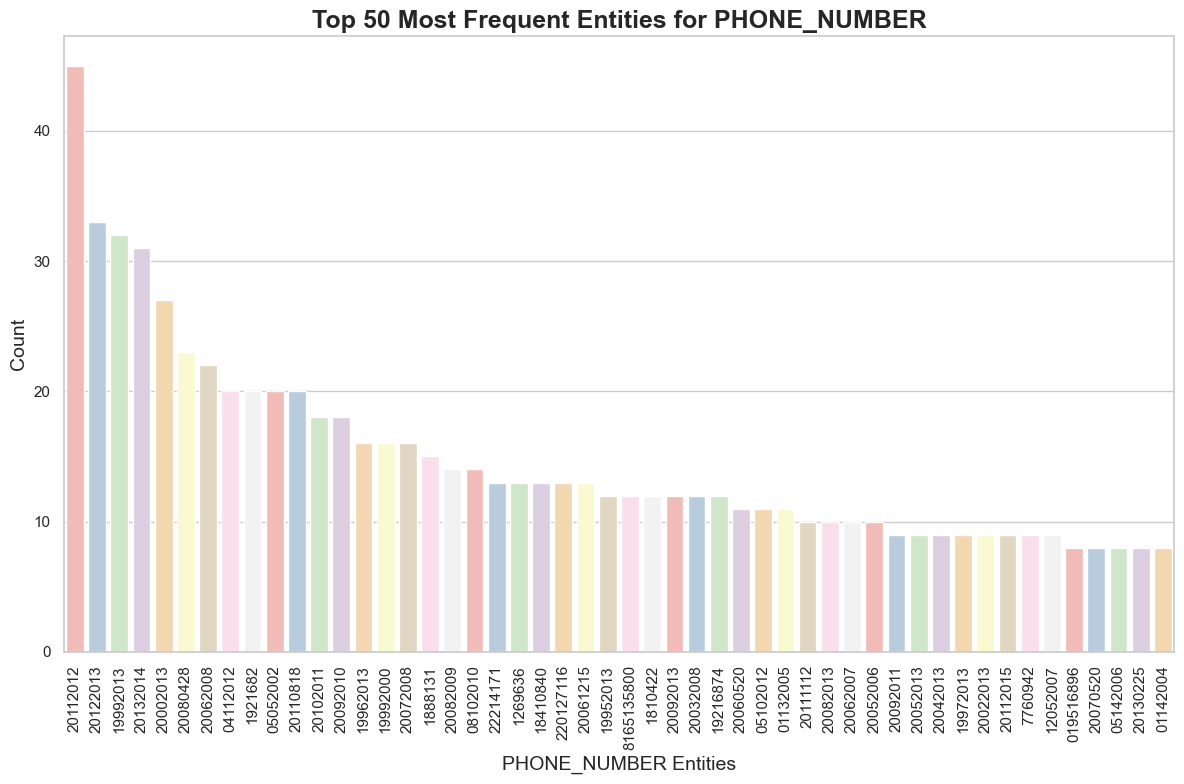

C:\Users\terry\AppData\Local\Temp\ipykernel_1385996\3244656915.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(entities), y=list(counts), palette=valid_palettes[i % len(valid_palettes)])


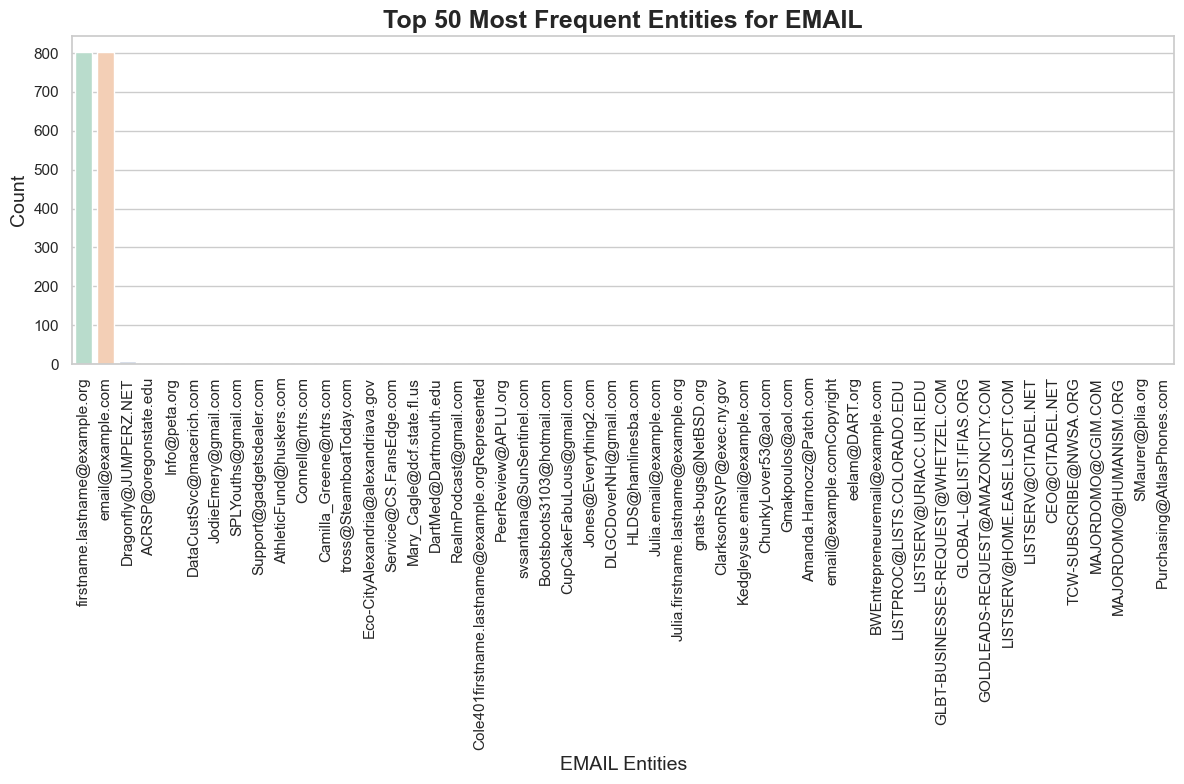

C:\Users\terry\AppData\Local\Temp\ipykernel_1385996\3244656915.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(entities), y=list(counts), palette=valid_palettes[i % len(valid_palettes)])


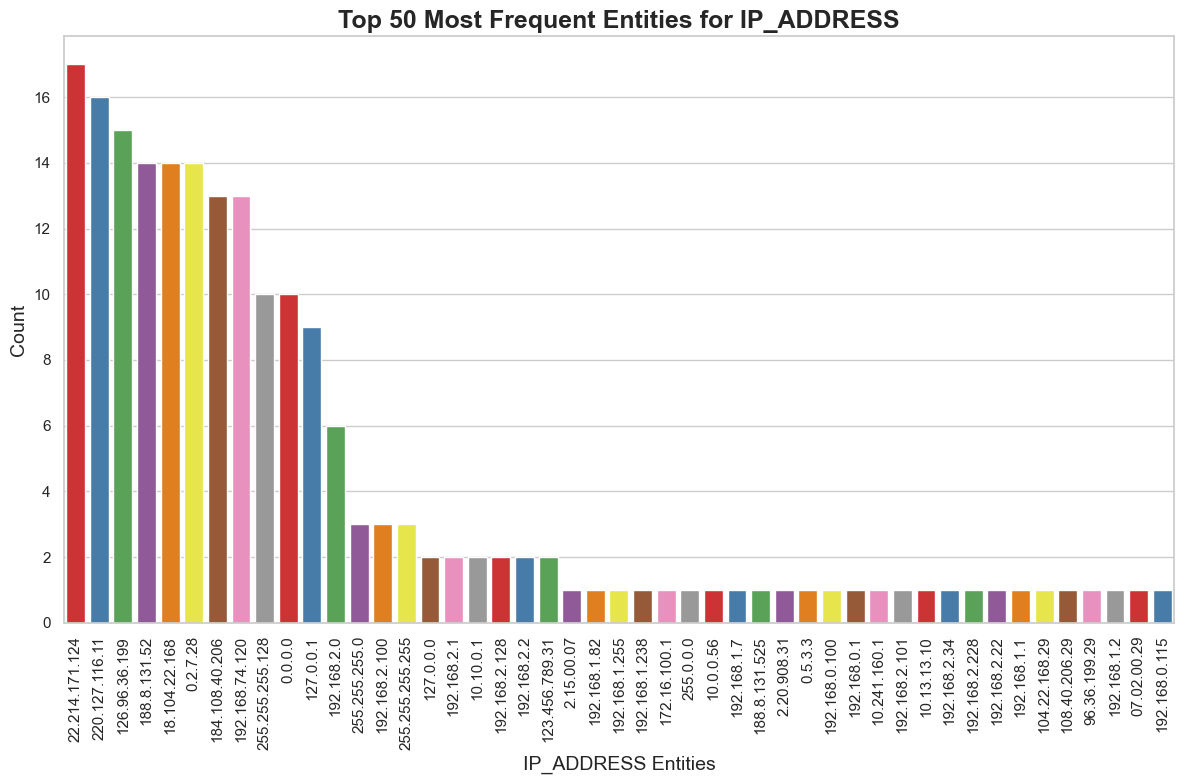


Top 10 Most Frequent PII Type Combinations:
GPE + PERSON: 12772
GPE + LOC: 3038
LOC + PERSON: 3002
GPE + LOC + PERSON: 2634
PERSON + PHONE_NUMBER: 2454
GPE + PHONE_NUMBER: 2436
GPE + PERSON + PHONE_NUMBER: 1855
EMAIL + PERSON: 885
EMAIL + GPE: 847
EMAIL + GPE + PERSON: 659


C:\Users\terry\AppData\Local\Temp\ipykernel_1385996\3244656915.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(combo_labels), y=list(counts), palette='coolwarm')


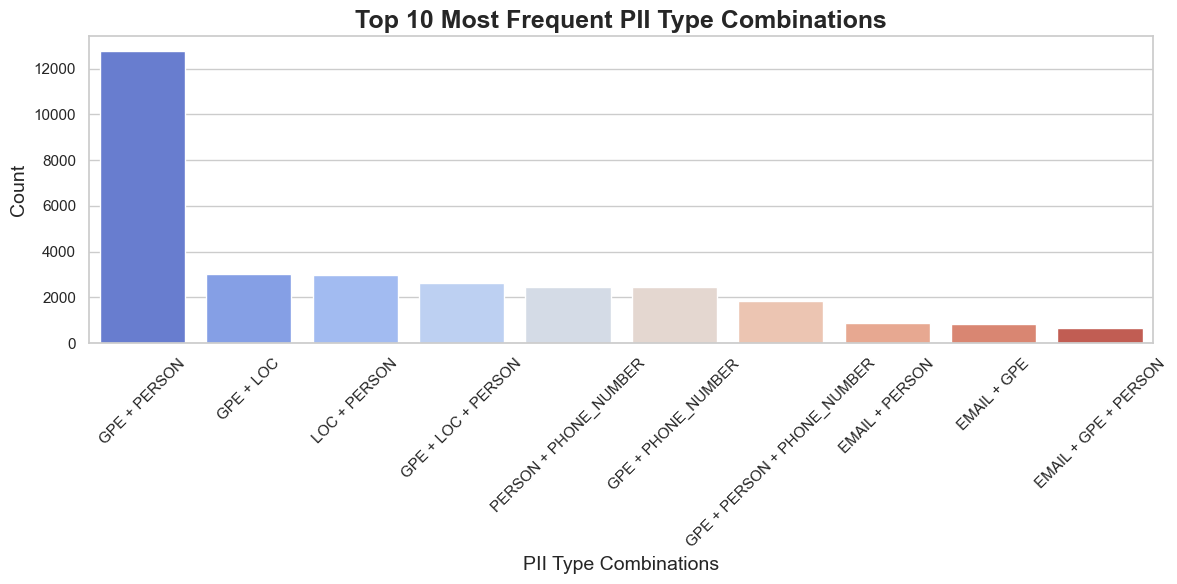

In [35]:
# Import necessary libraries
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
import pandas as pd
import seaborn as sns
import os

# Ensure plots display within the notebook (if using Jupyter)
%matplotlib inline

# Create the output directory if it doesn't exist
os.makedirs('./pics', exist_ok=True)

# Set general plot style for all plots
sns.set(style="whitegrid")

# --- Code starts here ---

# 1. Calculate General Statistics

# Extract PII counts by type from metrics
pii_counts = metrics['PII Counts by Type']

# Convert to a pandas DataFrame for easier plotting
pii_counts_df = pd.DataFrame.from_dict(pii_counts, orient='index', columns=['Count']).reset_index()
pii_counts_df.rename(columns={'index': 'PII Type'}, inplace=True)

# Display the DataFrame
print("PII Counts by Type:")
print(pii_counts_df)

# Bar chart for PII counts by type
plt.figure(figsize=(10, 6))
sns.barplot(data=pii_counts_df, x='PII Type', y='Count', palette='Blues_d')
plt.title('Count of Each PII Type Overall', fontsize=18, fontweight='bold')
plt.xlabel('PII Type', fontsize=14)
plt.ylabel('Total Count', fontsize=14)
plt.savefig('./pics/pii_count_by_type.pdf', format='pdf')
plt.show()

# Rate of Each PII Type Occurring Per Document

# Total number of documents processed
total_documents = len(extracted_pii_data)

# Calculate the rate (number of documents containing each PII type divided by total documents)
pii_document_counts = Counter()
for sample in extracted_pii_data:
    for pii_type in sample['extracted_pii'].keys():
        pii_document_counts[pii_type] += 1

# Convert to DataFrame
pii_rate_df = pd.DataFrame.from_dict(pii_document_counts, orient='index', columns=['Documents with PII']).reset_index()
pii_rate_df.rename(columns={'index': 'PII Type'}, inplace=True)
pii_rate_df['Rate per Document (%)'] = (pii_rate_df['Documents with PII'] / total_documents) * 100

# Display the DataFrame
print("\nRate of Each PII Type Occurring in Documents:")
print(pii_rate_df)

# Bar chart for PII rate per document
plt.figure(figsize=(10, 6))
sns.barplot(data=pii_rate_df, x='PII Type', y='Rate per Document (%)', palette='Purples')
plt.title('Rate of Each PII Type Occurring per Document', fontsize=18, fontweight='bold')
plt.xlabel('PII Type', fontsize=14)
plt.ylabel('Rate per Document (%)', fontsize=14)
plt.savefig('./pics/pii_rate_per_document.pdf', format='pdf')
plt.show()

# 2. Identify Most Common Individual Entities for Each PII Type

# Initialize a dictionary to hold counts for each PII type
pii_entity_counts = {}

# Iterate over extracted PII data to collect entity counts
for sample in extracted_pii_data:
    for pii_type, entities in sample['extracted_pii'].items():
        if pii_type not in pii_entity_counts:
            pii_entity_counts[pii_type] = Counter()
        pii_entity_counts[pii_type].update(entities)

# For each PII type, get the top 50 entities
top_entities_per_pii = {}
for pii_type, counter in pii_entity_counts.items():
    top_entities_per_pii[pii_type] = counter.most_common(50)  # Changed to top 50

# Display the top entities
for pii_type, top_entities in top_entities_per_pii.items():
    print(f"\nTop 50 Entities for PII Type '{pii_type}':")
    for entity, count in top_entities:
        print(f"{entity}: {count}")

# Plotting the top 50 entities for each PII type
valid_palettes = ['Set1', 'Set2', 'Set3', 'Pastel1', 'Pastel2']
for i, (pii_type, top_entities) in enumerate(top_entities_per_pii.items()):
    # Prepare data
    entities, counts = zip(*top_entities)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(entities), y=list(counts), palette=valid_palettes[i % len(valid_palettes)])
    plt.title(f"Top 50 Most Frequent Entities for {pii_type}", fontsize=18, fontweight='bold')
    plt.xlabel(f"{pii_type} Entities", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f'./pics/top_entities_{pii_type.lower()}.pdf', format='pdf')
    plt.show()

# 3. Determine Common PII Type Combinations

# Initialize a Counter for combinations
combination_counts = Counter()

# Iterate over each document to find combinations
for sample in extracted_pii_data:
    pii_types_in_doc = list(sample['extracted_pii'].keys())
    # Generate all possible combinations of PII types in the document
    for r in range(2, len(pii_types_in_doc) + 1):
        for combo in combinations(sorted(pii_types_in_doc), r):
            combination_counts[combo] += 1

# Get the top 10 most frequent combinations
top_combinations = combination_counts.most_common(10)

# Display the top combinations
print("\nTop 10 Most Frequent PII Type Combinations:")
for combo, count in top_combinations:
    print(f"{' + '.join(combo)}: {count}")

# Prepare data
combos, counts = zip(*top_combinations)
combo_labels = [' + '.join(combo) for combo in combos]

plt.figure(figsize=(12, 6))
sns.barplot(x=list(combo_labels), y=list(counts), palette='coolwarm')
plt.title("Top 10 Most Frequent PII Type Combinations", fontsize=18, fontweight='bold')
plt.xlabel("PII Type Combinations", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./pics/top_pii_combinations.pdf', format='pdf')
plt.show()


In [ ]:
!pip install spacy matplotlib datasets tqdm seaborn
!python -m spacy download en_core_web_sm